Based on the

[1]: Quantum Amplitude Amplification and Estimation, G. Brassard et al., 2000, https://arxiv.org/abs/quant-ph/0005055

[2]: Quantum Risk Analysis, S. Woerner and D.J. Egger, 2018, https://arxiv.org/abs/1806.06893

[3]: Amplitude Estimation without Phase Estimation, Y. Suzuki et al., 2020, https://arxiv.org/abs/1904.10246

***

# Amplitude amplification

Suppose we have a set $X$ and a function $f: X \rightarrow \{ 0,1\}$, which outputs $f(x)=0$ if $x$ is a bad element, and $f(x)=1$ if $x$ is a good element. In the case that arbitrarily chosen $x \in X$ is a good element with a probability $a$, we would have to call function $f$ on average $n=1/a$ times to find a good element. 
In quantum computing, the Quantum amplitude amplification can find the good element in $\mathcal{O}(\sqrt{n})$, allowing to solve the problem quadratically faster.

Consider an unitary quantum operator $A$ acting on a register of $m+1$ qubits as
    $$A |0\rangle_{m+1} = \sqrt{1-a} |\psi_0\rangle_m |0\rangle + \sqrt{a} |\psi_1\rangle_m |1\rangle,$$
where $|\psi_0\rangle_m$ and $|\psi_1\rangle_m$ are normalized states and $a$ is the probability to measure the state $|0\rangle$. By perforing multiple measurements on the state $A |0\rangle_{m+1}$, we could extract the probability $a$, but this would still be the complexity $\mathcal{O}(\sqrt{n})$. In order to cut down the required amount of operations $A$, we define the amplification operator
    $$Q = A S_0 A^{-1} S_{\psi},$$
where $S_0$ and $S_\psi$ are the reflection operators acting only on the all-zero and the good states respectively.
Defined as 
$$S_0 = I_{n+1} - 2|0\rangle_{n+1} \langle0|_{n+1},$$ 
the $S_0$ flips the phase of the all-zero state $|0\rangle$, 
while the 
$$S_{\psi_1} = I_{n+1} - 2|\psi_1 \rangle_n |1\rangle \langle \psi_1|_n \langle 1|$$
 flips the phase of the good-state . 

By defing the parameter $\theta_a = \arcsin(\sqrt{a})$, the state of the system after an operation $A$ as well as a $k$ number of operations $Q$ can be written as
$$ A |0\rangle_{m+1} = \cos(\theta_a) |\psi_0\rangle_m |0\rangle + \sin(\theta_a) |\psi_1\rangle_m |1\rangle $$
$$ Q^k A |0\rangle_{m+1} = \cos((2k+1)\theta_a) |\psi_0\rangle_m |0\rangle + \sin((2k+1)\theta_a) |\psi_1\rangle_m |1\rangle. $$

After the amplitude aplification process, the operator $A$ and its inverse are called total of $2k+1$ times, once at the beginning, and twice for every $Q$ operation.
For $0 \leqslant a \leqslant 1$, the probability to measure the state $|1\rangle$ after $k$ queries is then
$$ P_1 = \sin^2((2k+1)\theta_a), \qquad \text{where} \qquad 0 \leqslant \theta_a \leqslant \frac{\pi}{2}. $$
The good state can be then found succesfully if $P_1$ is close to 1. To this end, the amount of queries for $Q$ needs to be chosen appropriately, in order to get the best possible $P_1$.


# Single Qubit example
As a simple example, we consider an asset $V$, which has value of either $V_0=0$ with probability $1-p$ or $V_1=1$ with probability $p$. 
The value of the asset can be written as $V = (1-p)V_0 + pV_1$, which can be conviniently encoded into the single qubit as
    $$ A|0\rangle = \sqrt{1-p} |0\rangle + \sqrt{p} |1\rangle. $$

We will consider the amplitude estimation for this example implemented in two different ways.

1) First, we use the canonical amplitude estimation [1], which utilizes the quantum Fourier transform, as well as additional $m$ qubits used in the evaluation.

2) The second method [3] does not require any additional qubits and uses less gates, and is thus more suitable for the real quantum hardware currently available. This method relies on the classical post-processing in the form of maximum likelihood estimation.

# Choosing backend simulator

Can be run on

1) Noise-free simulators, such as Qiskit Aer.
2) Noisy simulators, for example IQMFakeAdonis with noise profile correspoding to Helmi Quantum computer. (Amount of available qubits limited by the choice of noise profile)
3) On real quantum computer, such as Helmi. Note that this requires access to the quantum computer. (Qubits again limited by the choice of hardware)

Backends used in this notebook are chosen in the cell below.

In [1]:
from qiskit import Aer
from iqm.qiskit_iqm import IQMFakeAdonis, IQMProvider
import os


#UNCOMMENT YOUR CHOICE OF BACKEND
#Noiseless simulator----------------------------------------------
#backend_simulator = Aer.get_backend('aer_simulator_statevector')
#-----------------------------------------------------------------

#Fake simulating Helmi--------------------------------------------
#backend_simulator = IQMFakeAdonis()
#-----------------------------------------------------------------

#Helmi quantum computer (Requires connection)---------------------
HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
provider = IQMProvider(HELMI_CORTEX_URL)
backend_simulator = provider.get_backend()
#-----------------------------------------------------------------



# Canonical QAE

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit.library import QFT

pi=np.pi

### Parameters

1) The probability `p_initial` for the asset $V = (1-p)V_0 + pV_1$

2) Number of evaluation qubits `m_qbit_eval`. Total qubits will `m_qbit_eval + 1`

3) Number of shots `shot_amont` as how many times the circuit is excecuted

In [3]:
p_initial = 0.3
m_qbit_eval = 4         #Total will be m_qbits+1
shot_amount_canonical = 100

### $A$-gate
Acting on the state $|0\rangle$, the operator $$A |0\rangle = \cos(\theta_a) |0\rangle + \sin(\theta_a) |1\rangle$$
can be implemented with Y-rotation defined by matrix
$$    R_y(\theta) = 
        \begin{pmatrix}
        \cos(\theta/2) & -\sin(\theta/2) \\
        \sin(\theta/2) & \cos(\theta/2)
        \end{pmatrix}, $$

such that $A = R_y(\theta)$, and $\theta = 2\arcsin(\sqrt{p})$.

In [4]:
def Build_A(p):
    circ = QuantumCircuit(1)
    theta = 2*np.arcsin(np.sqrt(p))
    circ.ry(theta, 0)
    return circ.to_gate(label='  A  ')

### $Q$-gate

Fist we define the reflection operators $S_0$ and $S_{\psi_1}$.

For one qubit, these operators really simple. The phases all-zero state $|0\rangle$ and good state $|1\rangle$ can be flipped with the use of $Z$ and $X$ gates as follows
$$ S_0 |0\rangle = XZX |0\rangle = 
        \begin{pmatrix}
        -1 & 0 \\
         0 & 1
        \end{pmatrix} 
        \begin{pmatrix}
        1 \\
        0
        \end{pmatrix} 
        = -|0\rangle $$

$$ S_{\psi_1} |1\rangle = Z |1\rangle = 
    \begin{pmatrix}
    1 & 0 \\
    0 & -1
    \end{pmatrix}
    \begin{pmatrix}
    0 \\
    1
    \end{pmatrix} 
    = -|1\rangle $$

As the global phase of the quantum system is irrevelant when it comes to measurements, we can write the amplification operator as $Q=A S_0 A^{-1} S_\psi = AZA^{-1}Z$. With some simple linea algebra, this simplifies to $Q=R_y(2 \theta)$.

For different powers of $Q$, we get
$$ Q^{2^k} = R_y(2^{k+1}\theta) $$

In [5]:
def Build_Q_powers(p, pow_k):
    circ = QuantumCircuit(1)
    theta = 2*np.arcsin(np.sqrt(p))
    circ.ry(pow_k*2*theta, 0)
    return circ

### Inverse Quantum Fourier Transform (IQFT)
We use qiskits' own class for Inverse Quantum Fourier Transform (IQFT). 

In [6]:
def Build_iqft(m):
    circ = QFT(num_qubits=m, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name='  IQFT  ')
    return circ

### Building the circuit

1) The evaluation qubits are prepared into the uniform superposition with Hadamard-gates. As the evaluation qubits are initially in the state $|0,...,0\rangle$, this has a same effect as the Quantum Fourier transform.
2) The $A$-gate encodes the amplitude of the good state into the objective qubit.
3) Perform the amplitude amplification by applying controlled operations $Q^{2^k}$ to the objective qubit, where $k$:th evaluation qubits acts as a control qubit. 
The information about the eigenvalue of the $Q^{2^k}$ is encoded into the phase of the evaluation qubit through the "phase kickback".
4) Applying IQFT to the evaluation qubits, to move back into the computational basis.
5) Measuring the evaluation qubits.

In [7]:
def Build_circuit_canonical(m, p):
    req_eval = QuantumRegister(m, 'eval')
    req_obj = QuantumRegister(1, 'obj')
    req_classical = ClassicalRegister(m, 'c')
    circ = QuantumCircuit(req_eval, req_obj, req_classical)
    A = Build_A(p)
    iqft = Build_iqft(m)
    circ.h(req_eval)
    circ.append(A, req_obj)
    for i in range(m):
        Q_label = "$Q$^" + str(2**i)
        Q_ctrl = Build_Q_powers(p, 2**i).to_gate(label=f"  {Q_label}  ").control()
        circ.append(Q_ctrl, [i] + [m])
    circ.append(iqft, req_eval)
    circ.measure(req_eval, req_classical)
    return circ

### Postprocessing

To recover the amplitude, $a \in [0,1]$, from the measured states, we use the mapping
$$\hat{a} = \sin^2(\frac{y\pi}{2^m}) \in [0,1],$$
where $y \in \{ 0,...,2^m-1 \}$ and $m$ is the number of evaluation qubits. 

The mapping is periodic in $2^m$, and symmetric such that $\sin^2(y\pi/2^m) = \sin^2((2^m-y)\pi/2^m)$

The speed-up of the quantum algorithm can be justified as follows.

Comparing the estimator $\hat{a} = \sin^2(y\pi/2^m)$ and the exact value $a = \sin^2(\theta)$, we can calculate the limit for the error
$$ |a - \hat{a}| \leqslant  \frac{\pi}{2^m} +  \frac{\pi^2}{(2^m)^2} = \mathcal{O}\bigg(\frac{1}{2^m}\bigg)$$

In comparison, the convergence rate of the classical algorithm is
$$ \mathcal{O}\bigg(\frac{1}{\sqrt{2^m}}\bigg) $$
which makes the quantum amplitude estimation quadratically faster.

In [8]:
def a_mapping(m, y):
    return np.sin(pi*y / (2**m))**2

Postprocessing for the measurements. We have to aggregate the amplitudes due to the symmetry of the estimator.

In [9]:
def postprocessing(m, measurements, shots):
    counts = list(measurements.values())
    states = list(measurements.keys())
    amps = np.zeros(2**m, dtype=float)

    #Mapping binaries representing measured states to the integers and
    #Filling in nonzero amplitudes
    for i, x in enumerate(states):
        decimal = int(str(x), 2)
        amps[decimal] = counts[i]/shots

    #Lists containing estimated values for amplitudes and corresponding frequencies based on measurements
    a_list = [a_mapping(m, x) for x in range(2**(m - 1) + 1)]
    freq_list = []

    #Aggregating amplitudes corresponding to the same states
    for i in range(int(2**(m - 1) + 1)):
        freq_list.append(amps[i] + amps[2**m-1 - i])

    # finding amplitude with highest frequency
    max_freq = round(max(freq_list), 3)
    a_res = round(a_list[np.argmax(freq_list)], 3)

    return a_list, freq_list, a_res, max_freq

### Running the simulation and printing the results

In [10]:
#Running
qc = Build_circuit_canonical(m_qbit_eval, p_initial)

job = execute(qc, backend_simulator, shots=shot_amount_canonical, optimization_level=3, circuit_duration_check=False)

counts = job.result().get_counts()
amps, frequencies, a_result, a_frequency = postprocessing(m_qbit_eval, counts, shot_amount_canonical)

queries = 1
for i in range(m_qbit_eval):
    queries += 2*(2**i)

print()
print(f"Evaluation qubits = {m_qbit_eval}")
print(f"            Shots = {shot_amount_canonical}")
print(f" Initial choice p = {p_initial}")
print()
print(f' Estimated result = {a_result}')
print(f"       Difference = {round(a_result - p_initial, 3)}")
#print(f"With frequency f = {a_frequency}")
print(f"     Oracle calls = {shot_amount_canonical*queries}")


Evaluation qubits = 4
            Shots = 100
 Initial choice p = 0.3

 Estimated result = 0.309
       Difference = 0.009
     Oracle calls = 3100


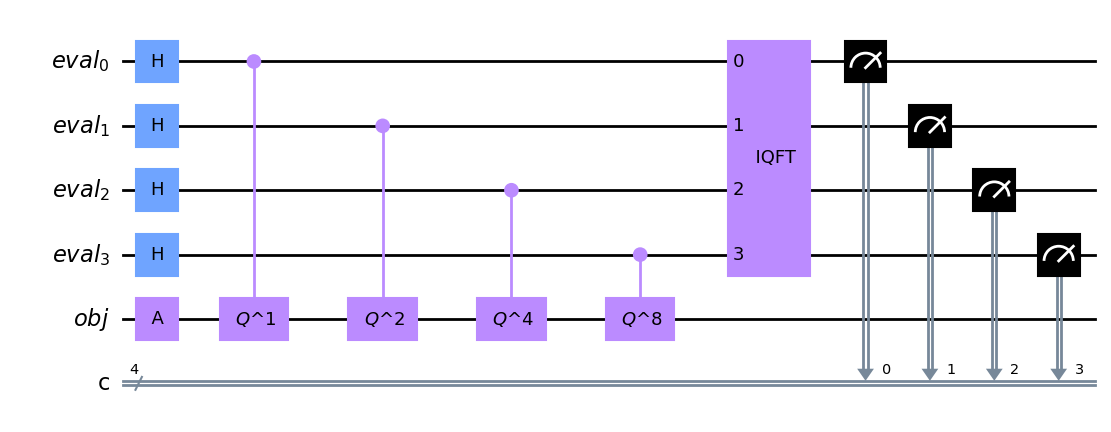

In [11]:
qc.draw('mpl', style="clifford")

# Maximum Likelihood Quantum Amplitude Estimation (MLQAE)

In the MLQAE, we run multiple circuits, comprised of $A$ and different powers of $Q$. Only the objective qubit is measured, and the post processing is done for the number of hits (measured good states). As the MLQAE does not use controlled $Q$-gates, the amount of CNOT gates is much smaller that in the canonical QAE.

First we import suitable library for minimizing functions.

In [12]:
from scipy import optimize

### Parameters

The additional parameters required by MLQAE

1) Number of different grovere iterations given by `grover_amount`

2) Shots for each circuit, given by $N=$`shot_amount_mlqae`

In [13]:
grover_amount = 5
shot_amount_mlqae = 50

#Exponential or linear Grover scheme
#grover_list = [0] + [2**x for x in range(grover_amount-1)]
grover_list = [0] + [x for x in range(1, grover_amount)]

shot_list = [shot_amount_mlqae for i in range(len(grover_list))]

### Building and simulation of the circuits

Using the same gates as in canonical QAE, the function returns a list of circuits with different iterations of Grover operators.

In [14]:
def Build_circuits_MLQAE(grovers, p):
    qcs = []
    A = Build_A(p)
    for i in range(len(grovers)):
        req_obj = QuantumRegister(1, 'obj')
        req_classical = ClassicalRegister(1, 'c')
        circ = QuantumCircuit(req_obj, req_classical)
        circ.append(A, req_obj)
        circ.barrier()
        Q = Build_Q_powers(p, grovers[i]).to_gate(label=f"  $Q^{str(2**(i))}$  ")
        #Q = Build_Q_powers(p, grovers[i]).to_gate(label='  $Q^m$  ')
        circ.append(Q, req_obj)
        circ.barrier()
        circ.measure(req_obj, req_classical)
        qcs.append(circ)
    return qcs

The objective qubit in each circuit is measured, and the number of measured good states for each circuit is saved.

In [15]:
def simulator_MLQAE(qcs, shots, backend):
    hits = []
    job = execute(qcs, backend=backend, shots=shots, optimization_level=3, circuit_duration_check=False)
    counts = job.result().get_counts()
    for i in range(len(counts)):
        hits.append(counts[i].get("1",0))
    return hits

### Postprocessing: Maximum likelihood estimation

For the circuit number $k$, let

1) $g_k$ be the amount of Grover operators,

2) $h_k$ be the amount of measured good states,

3) $N_k$ be the amount of shots. 

For measuring the single qubit, the possible results are either $0$ or $1$. For this probabilistic event, the logarithmic likelihood function can be written as
$$ L_K(h_k;\theta_a) = h_k\ln \big( \sin^2[(2m_k + 1)\theta_a] \big) + (N_k-h_k)\ln \big( \cos^2[(2m_k + 1)\theta_a] \big). $$

For all the circuits, the total likelihood function is then
$$ L(\textbf{h}, \theta_a) = \prod_{k=0}^{M}L_K(h_k;\theta_a) $$

The goal is to maximize the total likelihood function for $\theta_a$
$$ \hat{\theta}_a = \text{argmax}_{\theta_a} L(\textbf{h}, \theta_a), $$

so that $\hat{\theta_a}$ can be the used to estimate the amplitude
$$ \hat{a} = \sin^2(\hat{\theta_a}) $$


In [16]:
def loglikelihood(theta, g, hits, grovers, shots):
    value = 0.0
    for i in range(g + 1):
        arg = (2*grovers[i] + 1) * theta
        value += hits[i]*np.log(np.sin(arg)**2) + (shots[i] - hits[i])*np.log(np.cos(arg)**2)
        #The factor -1 as we want to maximize the function
    return -1*value

To make MLQAE faster than the classical algorithm, one needs to limit the oracle calls given by 
$$N_\text{oracle} = \sum_{k=0}^{M} N_k(2m_k + 1)$$

This advantage is achieved with the use of Fischer information
$$ \mathcal{F}(a) = \mathbb{E} \bigg[ \bigg( \frac{\partial L(\textbf{h}, a) }{\partial a} \bigg)^2 \bigg] = \frac{1}{a(1-a)} \sum_{k=0}^{M} N_k (2m_k + 1)^2. $$
The Fischer information measures the amount of information that the observable random variable (measurements) carry about the unknown paramater (amplitude $\hat{a}$ of the good state).

The Fischer information satisfies the Cramer Rao inequality
$$ \text{var}(\hat{a}) = \mathbb{E}[(\hat{a} - \mathbb{E}[\hat{a}])^2] \geqslant \bigg(1 + \frac{\partial \mathbb{E}[\hat{a} - a]}{\partial a}\bigg)^2/\mathcal{F}(a), $$
and consequently, the mean squared error
$$  \mathbb{E}[(\hat{a} - a)^2] = \text{var}(\hat{a}) + \mathbb{E}[\hat{a} - a]^2 
\geqslant \bigg(1 + \frac{\partial \mathbb{E}[\hat{a} - a]}{\partial a}\bigg)^2/\mathcal{F}(a) + \mathbb{E}[\hat{a} - a]^2 $$

With sufficient amount of measurements, the estimator $\hat{\theta}$ becomes unbiased, meaning it matches the actual measured values, thus $ \mathbb{E}[\hat{a} - a] \rightarrow 0 $.
By writing the error as $ \hat{\epsilon} = \sqrt{\mathbb{E}[(\hat{a} - a)^2]} $, we can clearly write lower bound for the error

$$ \hat{\epsilon} = \frac{1}{\sqrt{\mathcal{F}(a)}} = \sqrt{\frac{a(1-a)}{\sum_{k=0}^{M} N_k (2m_k + 1)^2}} \geqslant \frac{\sqrt{a(1-a)}}{N_\text{oracle}} $$

If we compare this to the classical case, where no Grover operators are applied, and set $m_k = 0$, the same error rate would become 
$$\hat{\epsilon} \geqslant \sqrt{a(1-a)/N_\text{oracle}}.$$

Clearly we, see the error scales in quantum case $\mathcal{O}(N_\text{oracle}^{-1})$, versus $\mathcal{O}(N_\text{oracle}^{-1/2})$ in classical case. This translates to the quadratic speed-up gained with quantum algorithm.

In [17]:
def error_rate(N, grovers, shots, p0):
    Fischer = 0.0
    for i in range(N+1):
        Fischer += shots[i]/(p0*(1 - p0)) * (2*grovers[i] + 1)**2
    error = np.sqrt(1/Fischer)
    return error

In the implementation of the maximum likehood estimation, we use the brute force search from `scipy.optimization` to minimize (or actually maximize) the likelihood function. After each circuit, the search range for the parameters is adjusted based on the Cramer-Rao bound.

In [18]:
def ml_estimation(hits, grovers, shots):
    thetas = []
    #Small parameter to avoid dividing with zero
    epsilon = 10**-15
    #Adjusting confidence affects the search ranges when minimizing he function
    confindence = 1
    range_min = 0.0 + epsilon
    range_max = pi/2 - epsilon
    for g in range(len(grovers)):
        searchRange = (range_min, range_max)
        r = optimize.brute(lambda x: loglikelihood(x, g, hits, grovers, shots), [searchRange], finish=None)
        theta0 = r
        thetas.append(theta0)
        p0 = np.sin(theta0)**2
        p_error = error_rate(g, grovers, shots, p0)
        theta_error = np.arcsin(np.sqrt(p_error))
        range_min = max(theta0 - confindence*theta_error , 0.0 + epsilon)
        range_max = min(theta0 + confindence*theta_error , pi/2 - epsilon)
    return thetas

Number of oracle calls in the algorthm is given by
$$ N_{\text{oracle}} =  \sum_k N_k (2m_k + 1) $$

In [19]:
def Oracle_Calls(N, grovers, shots):
    value = 0
    for i in range(N+1):
        value += shots[i]*(2*grovers[i] + 1)
    return value

### Running the simulation and printing the results

In [20]:
qcs = Build_circuits_MLQAE(grover_list, p_initial)
hitlist = simulator_MLQAE(qcs, shot_amount_mlqae, backend_simulator)
thetas = ml_estimation(hitlist, grover_list, shot_list)
amps = np.sin(thetas)**2

print()
print(f" Amount of shots = {shot_amount_mlqae}")
print(f"   Grover scheme = {grover_list}")
print(f"Initial choice p = {p_initial}")
print()
print(f"   Hits: {hitlist}")
print(f" Thetas: {thetas}")
print(f"Results: {amps}")
print()
print(f"Estimated amplitude = {round(amps[-1], 3)}")
print(f"         Difference = {round(amps[-1] - p_initial, 3)}")
print(f"       Oracle calls = {Oracle_Calls(grover_amount-1, grover_list, shot_list)}")


 Amount of shots = 50
   Grover scheme = [0, 1, 2, 3, 4]
Initial choice p = 0.3

   Hits: [12, 47, 4, 31, 33]
 Thetas: [0.49604094530365184, 0.4572351110842262, 0.5766770136750431, 0.5821885114573242, 0.5866244235983527]
Results: [0.22652592 0.19489481 0.29728814 0.30233858 0.30642087]

Estimated amplitude = 0.306
         Difference = 0.006
       Oracle calls = 1250


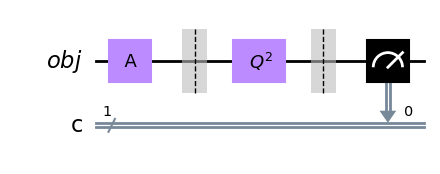

In [21]:
qcs[1].draw('mpl', style="clifford")